# Police Data Cleaning
## Crisis Data Dataset
### Exploration

Preview the data.

In [3]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
df = pd.read_csv('../Datasets/Crisis_Data.csv')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75082 entries, 0 to 75081
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Template ID                  75082 non-null  int64 
 1   Reported Date                75082 non-null  object
 2   Reported Time                75082 non-null  object
 3   Occurred Date / Time         75082 non-null  object
 4   Call Type                    75082 non-null  object
 5   Initial Call Type            75082 non-null  object
 6   Final Call Type              75082 non-null  object
 7   Disposition                  75082 non-null  object
 8   Use of Force Indicator       75082 non-null  object
 9   Subject Veteran Indicator    75082 non-null  object
 10  CIT Officer Requested        75082 non-null  object
 11  CIT Officer Dispatched       75082 non-null  object
 12  CIT Officer Arrived          75082 non-null  object
 13  Officer ID                   75

### Dealing with Missing Values
To make the missing data here more consistent, let's replace the dash values with None.

In [2]:
df.iloc[8:9,22:25]

,Precinct,Sector,Beat
8,-,-,-


In [3]:
df.replace({'-': None}, inplace=True)
df.iloc[8:9,22:25]

,Precinct,Sector,Beat
8,None,None,None


In [4]:
df.shape[0] - df.dropna().shape[0]

10328

There exist 10,328 rows with at least some missing data. 

In [5]:
df[(df['Officer Years of Experience'] == -1)].shape[0]


1056

In [6]:
df[(df['Officer Year of Birth'] == 1900)].shape[0]


377

There still exist some missing data in the integer columns in the form of officers being born in the year 1900, or officers having -1 years of experience. 

### Optimizing Datetime Columns

Let's look at optimizing the date columns.

In [7]:
df['Reported Date'].value_counts()['1900-01-01T00:00:00']

6

In [8]:
df['Occurred Date / Time'].value_counts()['01/01/1900 12:00:00 AM']

5600

There are some dates that are listed as occurring on January First, 1900. This must be a placeholder for missing / unknown data. Out of the 750082 entries, 6 have unknown reported dates, and 5600 have occurred dates that are unknown. 

In [9]:
date_cols = ['Reported Date', 'Reported Time', 'Occurred Date / Time']
for col in date_cols:
    df[col] = pd.to_datetime(df[col])


### Optimizing Numeric Columns
We can cast some columns such as the Officer Year of Birth to integer datatype and downcast it to the optimal subtype. The Officer ID columns has missing data, so it will remain as an object datatype. 


In [10]:
for col in ['Template ID', 'Officer Year of Birth', 'Officer Years of Experience']:
    df[col] = df[col].astype('int')
    df[col] = pd.to_numeric(df[col], downcast='integer')
    print(df[col].dtype, col)                               

int64 Template ID
int16 Officer Year of Birth
int8 Officer Years of Experience


### Optimizing Object Columns
Many columns have string values that repeat. We can optimize the space needed for this dataset by converting the columns with < 50% unique rows into category datatypes. 

In [11]:
for col in df.select_dtypes(include=['object']):
    num_unique_values = len(df[col].unique())
    num_total_values = len(df[col])
    print(col, num_unique_values, num_total_values)
    if num_unique_values / num_total_values < 0.5:
        df[col] = df[col].astype('category')

Call Type 9 75082
Initial Call Type 176 75082
Final Call Type 217 75082
Disposition 30 75082
Use of Force Indicator 2 75082
Subject Veteran Indicator 3 75082
CIT Officer Requested 2 75082
CIT Officer Dispatched 2 75082
CIT Officer Arrived 2 75082
Officer ID 1283 75082
Officer Gender 3 75082
Officer Race 9 75082
CIT Certified Indicator 2 75082
Officer Bureau Desc 7 75082
Officer Precinct Desc 27 75082
Officer Squad Desc 184 75082
Precinct 8 75082
Sector 18 75082
Beat 54 75082


## Condensing Cleaning
Knowing what we do now, many of these operations can be consolidated and run during reading of the csv file. 

In [12]:
dtypes = {
    'Template ID': 'int64',
    'Call Type': 'category',
    'Initial Call Type': 'category',
    'Final Call Type': 'category',
    'Disposition': 'category',
    'Use of Force Indicator': 'category',
    'Subject Veteran Indicator': 'category',
    'CIT Officer Requested': 'category',
    'CIT Officer Dispatched': 'category',
    'CIT Officer Arrived': 'category',
    'Officer ID': 'category',
    'Officer Gender': 'category',
    'Officer Race': 'category',
    'Officer Year of Birth': 'int16', 
    'Officer Years of Experience': 'int8', 
    'CIT Certified Indicator': 'category',
    'Officer Bureau Desc': 'category',
    'Officer Precinct Desc': 'category',
    'Officer Squad Desc': 'category',
    'Precinct': 'category',
    'Sector': 'category',
    'Beat': 'category',
}
date_cols = ['Reported Date', 'Reported Time', 'Occurred Date / Time']

df = pd.read_csv('../Datasets/Crisis_Data.csv', dtype=dtypes, parse_dates=date_cols)
df.replace({'-': None}, inplace=True)
df.iloc[15:20]

,Template ID,Reported Date,Reported Time,Occurred Date / Time,Call Type,Initial Call Type,Final Call Type,Disposition,Use of Force Indicator,Subject Veteran Indicator,CIT Officer Requested,CIT Officer Dispatched,CIT Officer Arrived,Officer ID,Officer Gender,Officer Race,Officer Year of Birth,Officer Years of Experience,CIT Certified Indicator,Officer Bureau Desc,Officer Precinct Desc,Officer Squad Desc,Precinct,Sector,Beat
15,44102,2015-05-16,2022-09-19 11:30:00,1900-01-01 00:00:00,NaN,NaN,NaN,Voluntary Committal,N,N,N,N,Y,7685,M,White,1973,3,N,NaN,NaN,NaN,NaN,NaN,NaN
16,43982,2015-05-16,2022-09-19 11:07:00,2015-05-16 22:50:33,"TELEPHONE OTHER, NOT 911",SERVICE - WELFARE CHECK,--CRISIS COMPLAINT - GENERAL,Emergent Detention / ITA,N,N,N,N,Y,7402,M,White,1973,15,N,OPERATIONS BUREAU,EAST PCT,EAST PCT 3RD W - EDWARD,East,EDWARD,E1
17,43719,2015-05-16,2022-09-19 05:58:00,2015-05-16 03:15:18,"TELEPHONE OTHER, NOT 911",UNKNOWN - ANI/ALI - WRLS PHNS (INCL OPEN LINE),--CRISIS COMPLAINT - GENERAL,Unable to Contact,N,N,Y,Y,Y,7787,M,White,1987,0,N,PROFESSIONAL STANDARDS BUREAU,TRAINING AND EDUCATION SECTION,TRAINING - FIELD TRAINING SQUAD,North,JOHN,J1
18,43832,2015-05-16,2022-09-19 01:24:00,2015-05-16 10:14:07,911,"DISTURBANCE, MISCELLANEOUS/OTHER",--DISTURBANCE - OTHER,Resources Declined,N,N,N,N,Y,7634,M,White,1977,2,N,OPERATIONS BUREAU,EAST PCT,EAST PCT 1ST W - E/G RELIEF (CHARLIE),East,CHARLIE,C3
19,43897,2015-05-16,2022-09-19 03:52:00,1900-01-01 00:00:00,NaN,NaN,NaN,Mobile Crisis Team,N,N,Y,Y,Y,4980,F,White,1962,30,N,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75082 entries, 0 to 75081
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Template ID                  75082 non-null  int64         
 1   Reported Date                75082 non-null  datetime64[ns]
 2   Reported Time                75082 non-null  datetime64[ns]
 3   Occurred Date / Time         75082 non-null  datetime64[ns]
 4   Call Type                    69482 non-null  category      
 5   Initial Call Type            69482 non-null  category      
 6   Final Call Type              69482 non-null  category      
 7   Disposition                  73463 non-null  category      
 8   Use of Force Indicator       75082 non-null  category      
 9   Subject Veteran Indicator    75081 non-null  category      
 10  CIT Officer Requested        75082 non-null  category      
 11  CIT Officer Dispatched       75082 non-nu

## Use of Force Dataset
### Exploration

Preview the data.

In [22]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv('https://data.seattle.gov/resource/ppi5-g2bj.csv?$limit=100000')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14636 entries, 0 to 14635
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   uniqueid           14636 non-null  object
 1   incident_num       14636 non-null  int64 
 2   incident_type      14636 non-null  object
 3   occured_date_time  14636 non-null  object
 4   precinct           14636 non-null  object
 5   sector             13557 non-null  object
 6   beat               14636 non-null  object
 7   officer_id         14636 non-null  int64 
 8   subject_id         14636 non-null  int64 
 9   subject_race       14636 non-null  object
 10  subject_gender     14636 non-null  object
dtypes: int64(3), object(8)
memory usage: 1.2+ MB


In [23]:
df.head()

,uniqueid,incident_num,incident_type,occured_date_time,precinct,sector,beat,officer_id,subject_id,subject_race,subject_gender
0,2014UOF-0001-1377-203,251,Level 1 - Use of Force,2014-06-07T00:09:00.000,East,CHARLIE,C2,1594,203,Black or African American,Male
1,2014UOF-0002-1098-166,218,Level 1 - Use of Force,2014-05-30T14:06:00.000,East,GEORGE,G1,1673,166,White,Male
2,2014UOF-0003-1031-125,178,Level 1 - Use of Force,2014-05-23T17:24:00.000,West,KING,K3,1690,125,Asian,Female
3,2014UOF-0004-767-126,179,Level 1 - Use of Force,2014-05-26T00:10:00.000,East,EDWARD,E2,953,126,Black or African American,Male
4,2014UOF-0005-1473-172,223,Level 1 - Use of Force,2014-06-01T16:03:00.000,South,ROBERT,R1,1145,172,Black or African American,Male


In [24]:
df['incident_type'].value_counts()

Level 1 - Use of Force    10428
Level 2 - Use of Force     3970
Level 3 - Use of Force      130
Level 3 - OIS               108
Name: incident_type, dtype: int64

In [25]:
df['precinct'].value_counts()

West         4140
North        3274
East         2873
South        2437
Southwest     833
-             688
X             371
0              12
OOJ             8
Name: precinct, dtype: int64

It looks like nearly 10% of the entries are missing a precinct.

In [26]:
df[(df['precinct'] == "X")]

,uniqueid,incident_num,incident_type,occured_date_time,precinct,sector,beat,officer_id,subject_id,subject_race,subject_gender
50,2014UOF-0053-627-522,553,Level 1 - Use of Force,2014-07-19T16:44:00.000,X,NaN,XX,913,520,Black or African American,Male
76,2014UOF-0076-375-389,439,Level 1 - Use of Force,2014-07-09T06:02:00.000,X,NaN,XX,302,388,White,Female
79,2014UOF-0080-1010-336,376,Level 1 - Use of Force,2014-07-01T06:00:00.000,X,NaN,XX,1220,335,White,Male
82,2014UOF-0083-1119-435,480,Level 1 - Use of Force,2014-07-12T11:20:00.000,X,NaN,XX,1800,434,Not Specified,Male
153,2014UOF-0154-1528-596,620,Level 1 - Use of Force,2014-07-23T22:12:00.000,X,NaN,XX,1180,594,Black or African American,Female
...,...,...,...,...,...,...,...,...,...,...,...
9286,2018UOF-2228-185-17914,39025,Level 1 - Use of Force,2018-12-21T18:06:00.000,X,NaN,XX,1697,18800,White,Male
9325,2018UOF-2266-1193-14243,39229,Level 1 - Use of Force,2018-12-29T06:15:00.000,X,NaN,XX,1779,15134,Hispanic or Latino,Male
9345,2018UOF-2289-176-17983,39208,Level 1 - Use of Force,2018-12-28T08:30:00.000,X,NaN,XX,1261,18869,Black or African American,Male
11333,2020UOF-0592-2218-7943,55886,Level 2 - Use of Force,2020-05-30T16:00:00.000,X,NaN,XX,2192,7884,Not Specified,Male



## Further topics for investigation
What percentage of crisis calls result in a CIT certified Officer responding per year?


# SPD Crime Data
This dataset contains neighborhood names, but the MCPP overlap different Beats.

In [56]:
import pandas as pd
pd.set_option('display.max_columns', None)
df = pd.read_csv('https://data.seattle.gov/resource/tazs-3rd5.csv?$limit=1500000', parse_dates=['offense_start_datetime', 'report_datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1007651 entries, 0 to 1007650
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   report_number           1007651 non-null  object        
 1   offense_id              1007651 non-null  int64         
 2   offense_start_datetime  1006568 non-null  datetime64[ns]
 3   offense_end_datetime    563000 non-null   object        
 4   report_datetime         1007651 non-null  datetime64[ns]
 5   group_a_b               1007651 non-null  object        
 6   crime_against_category  1007651 non-null  object        
 7   offense_parent_group    1007651 non-null  object        
 8   offense                 1007651 non-null  object        
 9   offense_code            1007651 non-null  object        
 10  precinct                1007647 non-null  object        
 11  sector                  1007649 non-null  object        
 12  beat          

In [57]:
df.head()


,report_number,offense_id,offense_start_datetime,offense_end_datetime,report_datetime,group_a_b,crime_against_category,offense_parent_group,offense,offense_code,precinct,sector,beat,mcpp,_100_block_address,longitude,latitude
0,2020-044620,12605873663,2020-02-05 10:10:00,NaN,2020-02-05 11:24:31,A,SOCIETY,DRUG/NARCOTIC OFFENSES,Drug/Narcotic Violations,35A,W,Q,Q1,MAGNOLIA,32XX BLOCK OF 23RD AVE W,-122.385974,47.649387
1,2020-044452,12605598696,2020-02-03 08:00:00,2020-02-04T08:00:00.000,2020-02-05 10:06:28,A,PROPERTY,LARCENY-THEFT,Theft of Motor Vehicle Parts or Accessories,23G,N,J,J3,ROOSEVELT/RAVENNA,63XX BLOCK OF 5TH AVE NE,-122.323399,47.675118
2,2020-044465,12605567653,2020-02-02 20:30:00,2020-02-02T21:30:00.000,2020-02-05 09:39:33,A,PROPERTY,ROBBERY,Robbery,120,N,U,U3,ROOSEVELT/RAVENNA,26TH AVE NE / NE BLAKELEY ST,-122.299552,47.666384
3,2020-044225,12605174036,2020-02-05 01:17:00,2020-02-05T02:21:00.000,2020-02-05 03:30:55,A,PROPERTY,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,Destruction/Damage/Vandalism of Property,290,W,Q,Q1,MAGNOLIA,22XX BLOCK OF W RAYE ST,-122.384865,47.642927
4,2020-044076,12605081469,2020-02-05 00:51:21,NaN,2020-02-05 00:51:31,B,SOCIETY,DRIVING UNDER THE INFLUENCE,Driving Under the Influence,90D,N,B,B2,BALLARD SOUTH,NW 46TH ST / 8TH AVE NW,-122.366195,47.662193


In [58]:
df['mcpp'].value_counts()


DOWNTOWN COMMERCIAL                 83031
CAPITOL HILL                        61528
NORTHGATE                           57305
QUEEN ANNE                          51042
SLU/CASCADE                         44612
UNIVERSITY                          39814
ROOSEVELT/RAVENNA                   35976
BALLARD SOUTH                       31883
FIRST HILL                          30500
LAKECITY                            28002
BELLTOWN                            27418
CHINATOWN/INTERNATIONAL DISTRICT    27157
CENTRAL AREA/SQUIRE PARK            25866
GREENWOOD                           21961
SANDPOINT                           21546
BALLARD NORTH                       20758
BITTERLAKE                          20042
FREMONT                             18779
WALLINGFORD                         18604
NORTH BEACON HILL                   17807
PIONEER SQUARE                      17146
SODO                                17087
MAGNOLIA                            15880
ROXHILL/WESTWOOD/ARBOR HEIGHTS    

Let's fix this spelling error and normalize the unknown data in this column.

In [59]:
df['mcpp'].replace({'CAPTIOL HILL': 'CAPITOL HILL', '<Null>': 'UNKNOWN'}, inplace=True)

Let's visualize the distribution of crime reports in each Micro-Community Policing Plan (MCPP).

<AxesSubplot:>

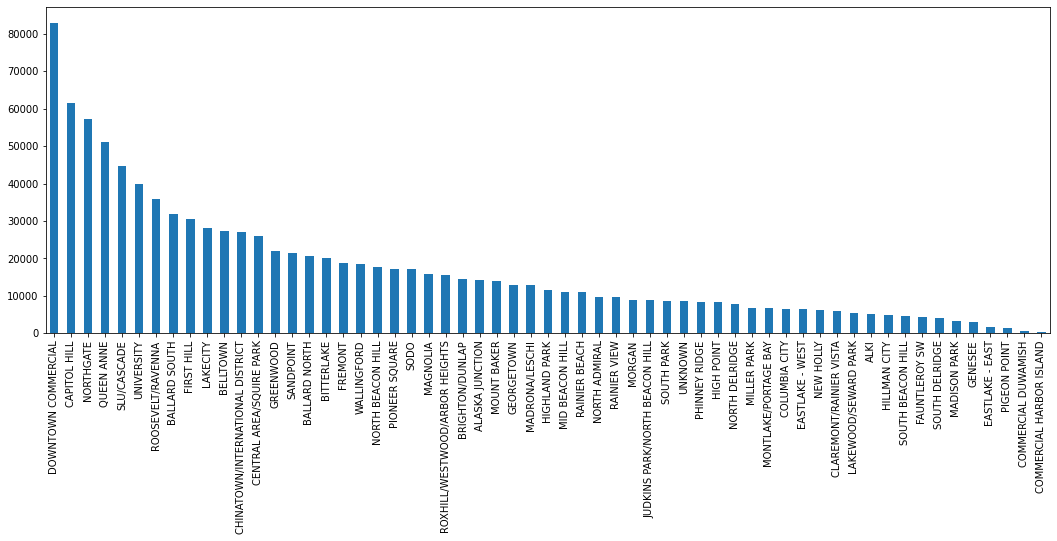

In [60]:
df['mcpp'].value_counts().plot.bar(stacked=True, figsize=(18, 6))

Let's try to visualize the change in crime over time on a per-neighborhood basis. We can count the crime reports per year and plot the totals over year. To start we'll add a `year` column to the dataset.

In [62]:
df['year'] = df['offense_start_datetime'].dt.year
df = df[(df['year'] > 2005)]
# df.year.hist(by=df['mcpp'], grid=False, rwidth=.9, figsize=(24, 12))

<AxesSubplot:>

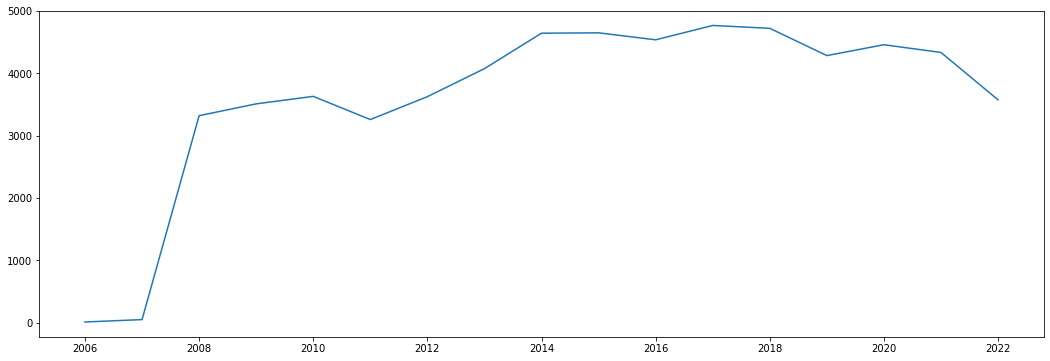

In [67]:
df['year'][df['mcpp'] == 'CAPITOL HILL'].value_counts().sort_index(key=0).plot.line(figsize=(18, 6))